# How do I make my custom QRenderer

This notebook demonstrates how to create a user-defined QRenderer. These steps are needed when you intend to configure Qiskit Metal to interface with your favorite (and presently not supported) external tool/simulator.

To execute all the steps in this notebook, you will be modifying the core code. Therefore, we assume that you have installed qiskit-metal from the github repository, using the README instructions, which will install qiskit-metal in 'editable' mode.

### Preparations
To get started, enable [automatic reloading of modules](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload). This will allow to modify the source code and immediately observe the effects of the changes in the notebook, without the need for reinitiating the kernel or reinstalling the package.

In [1]:
%load_ext autoreload
%autoreload 2

Pre-load all the Qiskit Metal libraries that are needed for the rest of this notebook.

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross

from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer

## Integrating the user-defined renderer with the rest of Qiskit Metal
### Architectural insights
This section will give you the architectural overview of how Qiskit Metal manages renderers, and how you can add your own.

We will refer to your custom renderer as the `skeleton` renderer, since we will not code tool-specific methods/classes, but only worry about how to bootstrap one without functionality.

Note that all renderers (existing `gds`, `hfss` and `q3d` as well as the newly created `skeleton`) have to be identified in the config.py file.  Therefore, you will be required to modify the `qiskit_metal/config.py` file.

The following image describe how the QRenderer (superclass of all renderers) interacts with the rest of Qiskit Metal.  The key take-away is that creating a QDesign class object initiates all the QRenderer subclass objects as well.  Specifically, the `QDesign.__init__()` method reads the `renderers_to_load` dictionary from the config.py file, which enumerates which QRenderers subclasses need to be instantiated.  After instantiating the renderer objects, the `QDesign.__init__()` registers them in the `QDesign._renderers` dictionary for later reference.

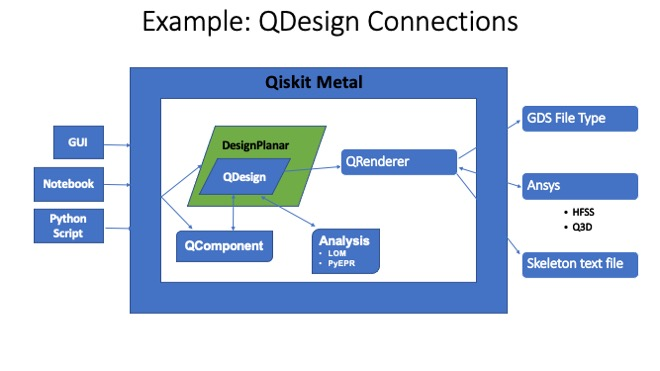

### QRenderer inheritance and subclass management

Presently, the config.py file references three QRenderers subclasses, which handle the `gds`, `hfss` and `q3d` interfaces.  Explicitly, QGDSRenderer is a subclass of QRenderer.  Both QHFSSRenderer and QQ3DRenderer subclass from QAnsysRenderer.  The class QAnsysRenderer is a subclass of QRenderer.

The `renderers_to_load` dictionary in the config.py file needs to be updated to inform Qiskit Metal about the new renderer `skeleton` you are going to create.  `renderers_to_load` stores the explicit path and class name so that Qiskit Metal will load to memory by default only those specified renderers. This happens during the `QDesign.__init__()`.

For this notebook, we created a sample class named QSkeletonRender in `tutorials/resources/skeleton_renderer`.  This class is your skeleton to develop a new QRenderer subclass.  Feel free to edit the class content at will. If you change the path to the file, please reflect that in the remainder of this notebook.  Presently, you can find the production QRenderers subclasses in the package directory `qiskit_metal.renderers`.

### TODO: Let's tell Qiskit Metal where to find your new custom renderer
As the first step, please locate and open the file config.py in the qiskit-metal package and edit the `renderers_to_load` dictionary to add the new renderer `skeleton`, like so:

`renderers_to_load = Dict(
    hfss=Dict(path_name='qiskit_metal.renderers.renderer_ansys.hfss_renderer',
              class_name='QHFSSRenderer'),
    q3d=Dict(path_name='qiskit_metal.renderers.renderer_ansys.q3d_renderer',
             class_name='QQ3DRenderer'),
    gds=Dict(path_name='qiskit_metal.renderers.renderer_gds.gds_renderer',
             class_name='QGDSRenderer'),
    skeleton=Dict(path_name='tutorials.resources.skeleton_renderer',
                  class_name='QSkeletonRenderer'),
)`

### Confirm QDesign is able to load your renderer
Create a QDesign instance.

In [3]:
design = designs.DesignPlanar()

If you modified the config.py correctly, the previous command should have instantiated and registered the `skeleton` renderer.  Verify that by inspecting the renderers dictionary property of the QDesign instance.

If executing the next cell does not show the `skeleton` renderer in the list, please make sure you correctly updated the `setup.py` file, next you could try resetting the jupyter notebook kernel, or restarting jupyter notebook.

In [4]:
design.renderers.keys()

dict_keys(['hfss', 'q3d', 'gds', 'skeleton'])

For convenience, let's create a short-handle alias to refer to the renderer during the remainder of this notebook.

In [5]:
a_skeleton = design.renderers.skeleton

## Interact with your new user-custom renderer

### Verify and modify the options of your renderer

In the QSkeletonRenderer class some sample `default_options` class parameter has been defined. <br>
`default_options = Dict(
     number_of_bones='206')
`

The instance `a_skeleton` will contain a dictionary `options` that is initiated using the `default_options`. (This works similarly to `options` for QComponents, which has been introduced in the jupyter notebooks found in the folder: `tutorials/2 Front End User`.)

You can access and modify the options in the QSkeletonRenderer class instance as follows.  For example, let's update the skeleton from that of a human to that of a dog (319 bones).

In [6]:
a_skeleton.options.number_of_bones = '319'
a_skeleton.options

{'number_of_bones': '319'}

Original values will continue being accessible like so:

In [7]:
a_skeleton.get_template_options(design)

{'number_of_bones': '206'}

### Populate a sample QDesign to demonstrate interaction with the renderer
This portion is described in notebooks within directory `tutorials/2 Front End User`. Some of the options have been made distinctly different to show what can be done, i.e. fillet value, fillet='25um', varies for each cpw.  However, that may not be what user will implement for their design.

In [8]:
gui = MetalGUI(design)
design.overwrite_enabled = True

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [9]:
## Custom options for all the transmons
options = dict(
    pad_width = '425 um',
    pad_gap = '80 um',
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict( 
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        d = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 TransmonPockets
q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.55mm', pos_y='+0.0mm', gds_cell_name='FakeJunction_02', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.9mm', orientation = '90', gds_cell_name='FakeJunction_02', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.55mm', pos_y='+0.0mm', gds_cell_name='FakeJunction_01',**options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.9mm', orientation = '90', gds_cell_name='my_other_junction', **options))

options = Dict(
    meander=Dict(
        lead_start='0.1mm',
        lead_end='0.1mm',
        asymmetry='0 um')
)

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='50um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        lead=Dict(
            start_straight='0.13mm',
            end_straight='0.13mm'
        ),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 90
cpw1 = connect('cpw1', 'Q1', 'd', 'Q2', 'c', '5.7 mm', f'+{asym}um', fillet='25um')
cpw2 = connect('cpw2', 'Q3', 'c', 'Q2', 'a', '5.6 mm', f'-{asym}um', flip=True, fillet='100um')
cpw3 = connect('cpw3', 'Q3', 'a', 'Q4', 'b', '5.5 mm', f'+{asym}um', fillet='75um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'd', '5.8 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

### Export list of the design QGeompetries to file using your custom QSkeletonRenderer
The QSkeletonRenderer class contains several sample methods. Let's use one intended to print out the name of the QGeometry tables to a text file (Remember: QGeometry contains the list of the raw layout shapes that compose the design, which we have created in the previous cell).

In [10]:
a_skeleton.write_qgeometry_table_names_to_file('./simple_output.txt')

1

Here another example where we subselect a single QComponent instance (`cpw1`) of type RouteMeander.  This will only export the name of tables containing shapes related to that instance, which in this case is only paths, and not junctions or poly.

In [11]:
a_skeleton.write_qgeometry_table_names_to_file('./simple_output_cpw1.txt',highlight_qcomponents=['cpw1'])

1

## What if my new tool requires additional parameters that Qiskit Metal does not natively support?

### QRenderers can request special tool parameters from the user

External tools, such as Ansys, might require special parameters to be able to render (interprete) correctly the QGeometries that Qiskit Metal wants to pass (render) to them.  Every tool might need a different set of special parameters, thus we architected a solution that allows individual QRenderer's to communicate to qiskit-metal what additional parameters their associated tool requires.

The implementation consists of enabling the QRenderer's to add new columns (parameters) and tables (geometry types) to the QGeometry table collection.  The QRenderer should also specify what is the default values to use to populate those columns/tables.  The user can then update them to a value different then default by editing them at run-time, which can happen thorugh the QComponent options (or directly, for advanced users).  Note that older QComponents remain valid also for newer QRenderer's, thanks to the defaults provided by the QRenderer.

Our QSkeletonRenderer class for example is designed to add a `a_column_name` column to the `junction` table, with default value `a_default_value`. This is implemented by creating the following class parameter: 
<br>`element_table_data = dict(junction=dict(a_column_name='a_default_value'))` 

Note that the final column name will be `skeleton_a_column_name` because the provided column name is prefixed with the renderer name (`QSkeletonRenderer.name`).

The method that executes the magic described above is `QRenderer.load()`, which is called from the `QSkeletonRenderer.__init__()`.

### Let's observe and update the additional properties that our QSkeletonRenderer needs
First, make sure that the registration of the QRenderer added the additional paramter as expected. Search for the column `skeleton_a_column_name` in the qgeometry table `junction`

In [12]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name,skeleton_a_column_name
0,1,rect_jj,"LINESTRING (2.55000 -0.04000, 2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02,a_default_value
1,2,rect_jj,"LINESTRING (0.04000 -0.90000, -0.04000 -0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02,a_default_value
2,3,rect_jj,"LINESTRING (-2.55000 -0.04000, -2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_01,a_default_value
3,4,rect_jj,"LINESTRING (0.04000 0.90000, -0.04000 0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction,a_default_value


If you cannot locate the new column (might need to scroll to the far right), then something must be amiss, so please start over this notebook and execute all of the cells.

Once you can locate the new column, and observe the set default value, let's not try to update the value in the column by modifying the design of the correspondent QComponent.  All we need to do is pass a different set of options to the component, like so:

In [13]:
q1.options.skeleton_a_column_name = 'q1 skeleton'
q2.options.skeleton_a_column_name = 'q2 skeleton'
q3.options.skeleton_a_column_name = 'q3 skeleton'
q4.options.skeleton_a_column_name = 'q4 skeleton'

gui.rebuild()
gui.autoscale()

design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name,skeleton_a_column_name
0,1,rect_jj,"LINESTRING (2.55000 -0.04000, 2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02,q1 skeleton
1,2,rect_jj,"LINESTRING (0.04000 -0.90000, -0.04000 -0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02,q2 skeleton
2,3,rect_jj,"LINESTRING (-2.55000 -0.04000, -2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_01,q3 skeleton
3,4,rect_jj,"LINESTRING (0.04000 0.90000, -0.04000 0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction,q4 skeleton


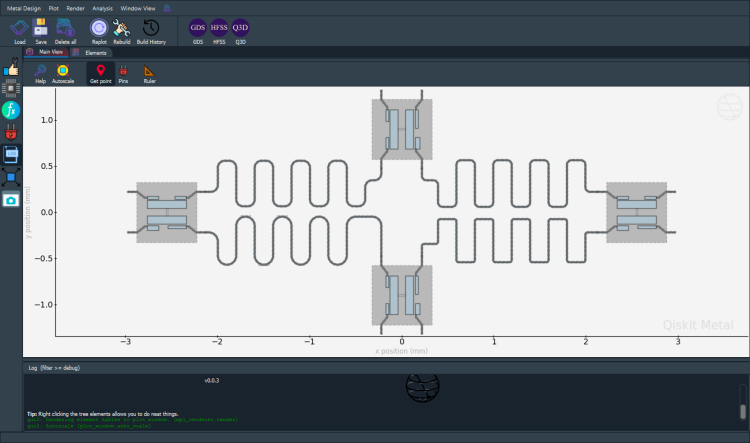

In [14]:
gui.screenshot()

You can also create the components by directly passing the options you know the renderer will require, like so:

In [15]:
q1.delete()
q2.delete()
q3.delete()
q4.delete()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.55mm', pos_y='+0.0mm', gds_cell_name='FakeJunction_02', skeleton_a_column_name='q1 skeleton 2', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.9mm', orientation = '90', gds_cell_name='FakeJunction_02', skeleton_a_column_name='q2 skeleton 2', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.55mm', pos_y='+0.0mm', gds_cell_name='FakeJunction_01', skeleton_a_column_name='q3 skeleton 2', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.9mm', orientation = '90', gds_cell_name='my_other_junction', skeleton_a_column_name='q4 skeleton 2', **options))

design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name,skeleton_a_column_name
0,9,rect_jj,"LINESTRING (2.55000 -0.01500, 2.55000 0.01500)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02,q1 skeleton 2
1,10,rect_jj,"LINESTRING (0.01500 -0.90000, -0.01500 -0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02,q2 skeleton 2
2,11,rect_jj,"LINESTRING (-2.55000 -0.01500, -2.55000 0.01500)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_01,q3 skeleton 2
3,12,rect_jj,"LINESTRING (0.01500 0.90000, -0.01500 0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction,q4 skeleton 2


## Can my user-defined renderer change/interact with the design?
### Accessing information and methods
It is possible that the resoult of a renderering action, or analysis requires a design update back to qiskit-metal.  This can be achieved wthout the user intervetion by simply controlling the QDesign instance from within the QRenderer.

Just as an example, the next three cells inspect the current design QComponent, QGeometry table, and QRenderer names.

In [16]:
a_skeleton.design.components.keys()

['cpw1', 'cpw2', 'cpw3', 'cpw4', 'Q1', 'Q2', 'Q3', 'Q4']

In [17]:
a_skeleton.design.qgeometry.tables.keys()

dict_keys(['path', 'poly', 'junction'])

In [18]:
a_skeleton.design.renderers.keys()

dict_keys(['hfss', 'q3d', 'gds', 'skeleton'])

The base QRenderer class comes with useful methods to more easily access some of the information. You will find more method described in the QRenderer documentation. The example below for example returns the QComponent's IDs.

In [19]:
a_skeleton.get_unique_component_ids(highlight_qcomponents = ['Q1', 'Q1', 'Q4', 'cpw1', 'cpw2', 'cpw3', 'cpw4'])

([7, 5, 12, 8, 6, 9], 0)

The following instead shows three ways to access the same QGeometry table.

In [20]:
a_skeleton.design.components['Q1'].qgeometry_table('junction') # via QComonent name
a_skeleton.design._components[9].qgeometry_table('junction') # via QComponent ID
q1.qgeometry_table('junction') # via the QComponent instance

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name,skeleton_a_column_name
0,9,rect_jj,"LINESTRING (2.55000 -0.01500, 2.55000 0.01500)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02,q1 skeleton 2


The method `QSkeletonRenderer.get_qgeometry_tables_for_skeleton()` exemplifies how to iterate through chips and tables.

In [21]:
from tutorials.resources.skeleton_renderer import QSkeletonRenderer
?QSkeletonRenderer.get_qgeometry_tables_for_skeleton

### Communicate state
We can also interact with any other method of the QDesign instance, for example we can generate a warning into the logger as shown in the next cell.  This is particularly useful to document problems with the user-defined QRenderer execution

In [22]:
# Purposefully generates an warning message.  
a_skeleton.logger.warning('Show a warning message for plugin developer.')

12:36PM 34s WARNING [<module>]: Show a warning message for plugin developer.


## Qiskit Metal Version

In [23]:
metal.about();


Qiskit Metal        0.0.3

Basic
____________________________________
 Python              3.7.8 | packaged by conda-forge | (default, Nov 27 2020, 18:48:03) [MSC v.1916 64 bit (AMD64)]
 Platform            Windows AMD64
 Installation path   c:\workspace\qiskit-metal\qiskit_metal

Packages
____________________________________
 Numpy               1.19.5
 Qutip               4.5.3

Rendering
____________________________________
 Matplotlib          3.3.4

GUI
____________________________________
 PySide2 version     5.13.2
 Qt version          5.9.7
 SIP version         4.19.8

IBM Quantum Team


In [24]:
# This command is below if the user wants to close the Metal GUI.
# gui.main_window.close()